In [ ]:
# https://www.kaggle.com/t/84398e118c78461da967baf927eb663f
# https://minglunwu.github.io/notes/2020/20200324.html#常會使用到的Module
# https://colab.researczh.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=lOqcmYzMO7jB

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 資料來源


# Package

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

seed = 5566
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [125]:
X = [[4, 1, 2, 2],
     [1, 3, 9, 3],
     [5, 7, 5, 1]]
transformer = Normalizer().fit(X)  # fit does nothing.
transformer

transformer.transform(X)

array([[0.8, 0.2, 0.4, 0.4],
       [0.1, 0.3, 0.9, 0.3],
       [0.5, 0.7, 0.5, 0.1]])

In [130]:
transformer.get_params()

{'copy': True, 'norm': 'l2'}

In [2]:
## reading data
df = pd.read_csv("training_data.csv")
train = df.sample(frac=0.8,random_state=seed) #random state is a seed value
validation = df.drop(train.index)
test = pd.read_csv("testing_data.csv")

## feature selection
remove "CO", "NO2" since their correlation to others is too high( > .7)

In [3]:
train.corr()

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,PM10,PM2.5,RH,SO2
AMB_TEMP,1.000000,-0.475609,-0.452942,-0.048137,-0.072113,-0.485297,-0.393812,-0.299611,-0.299368,-0.298359,0.015480
CH4,-0.475609,1.000000,0.595745,0.259751,0.327504,0.648481,0.623509,0.530213,0.527636,0.330632,0.208774
CO,-0.452942,0.595745,1.000000,0.523426,0.487895,0.792449,0.798460,0.555900,0.594292,0.176239,0.461610
NMHC,-0.048137,0.259751,0.523426,1.000000,0.429780,0.553926,0.595574,0.134293,0.136859,0.249881,0.432253
NO,-0.072113,0.327504,0.487895,0.429780,1.000000,0.414558,0.732427,0.116712,0.121922,0.137638,0.325409
NO2,-0.485297,0.648481,0.792449,0.553926,0.414558,1.000000,0.922513,0.476256,0.467125,0.320722,0.464323
NOx,-0.393812,0.623509,0.798460,0.595574,0.732427,0.922513,1.000000,0.405945,0.401213,0.297684,0.485008
PM10,-0.299611,0.530213,0.555900,0.134293,0.116712,0.476256,0.405945,1.000000,0.857992,-0.093898,0.332688
PM2.5,-0.299368,0.527636,0.594292,0.136859,0.121922,0.467125,0.401213,0.857992,1.000000,-0.067787,0.322223
RH,-0.298359,0.330632,0.176239,0.249881,0.137638,0.320722,0.297684,-0.093898,-0.067787,1.000000,-0.111448


In [4]:
feature_selected = ['AMB_TEMP', 'CH4', 'NMHC', 'NO', 'NOx', 'PM10', 'RH', 'SO2']

# Normalization

In [140]:
scalerX = StandardScaler().fit(train[feature_selected])
muY = train["PM2.5"].mean()
sY = train["PM2.5"].std()
# scalerY = StandardScaler().fit(train["PM2.5"])

In [136]:
scalerX.inverse_transform(scalerX.transform(train[feature_selected]))

array([[2.60e+01, 1.70e+00, 9.00e-02, ..., 6.00e+01, 6.70e+01, 3.00e+00],
       [2.60e+01, 1.70e+00, 2.00e-01, ..., 2.50e+01, 7.30e+01, 3.90e+00],
       [2.10e+01, 1.90e+00, 1.10e-01, ..., 8.50e+01, 8.40e+01, 2.30e+00],
       ...,
       [2.90e+01, 1.70e+00, 1.50e-01, ..., 2.70e+01, 7.80e+01, 4.00e+00],
       [2.00e+01, 1.70e+00, 1.30e-01, ..., 6.10e+01, 7.40e+01, 3.30e+00],
       [2.60e+01, 1.90e+00, 2.30e-01, ..., 1.24e+02, 8.00e+01, 7.00e+00]])

In [154]:
(train["PM2.5"].values - muY) / sY

array([ 0.11505131, -0.81093676,  1.23598424, ..., -0.56725569,
        0.11505131,  1.91829124])

In [6]:
train[feature_selected].shape

(7027, 8)

In [8]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [166]:
class PM25Dataset(Dataset): 
  def __init__(self, df:pd.DataFrame, mode="train"): 
    self.df = df
    self.mode = mode
    self.data = torch.FloatTensor(self.df.values)
    self.dim = len(feature_selected)
    ## standardize x in scaler
    self.x = torch.FloatTensor(scalerX.transform(self.df[feature_selected].values))
    if self.mode in ["train", "validation"]:
      self.y = torch.FloatTensor((self.df["PM2.5"].values - muY) / sY)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    if "test" == self.mode:
      return self.x[idx]
    ## train, validation sets
    return self.x[idx], self.y[idx]

train_ds = PM25Dataset(train)

In [156]:
eg = train_ds[0]
eg
# feature, label = eg["x"], eg["y"]
# feature

(array([ 0.139474  , -0.61711107, -0.49221637, -0.69438639, -0.51214751,
         0.24282214, -0.89853532,  0.11811844]), tensor(0.1151))

In [157]:
data_loader = DataLoader(dataset= train_ds, batch_size= 4, shuffle= True, num_workers= 2, pin_memory= True)
for x, y in data_loader:
  print(x, y)
  break
# print(len(data_loader)) #回傳當前共有幾個batch，可以直接用這個數值來作為Step.

# x, y = iter(data_loader).next() # 透過這種方式來取用資料。
# x

tensor([[-0.4127,  1.7442,  0.3670,  1.0861,  0.9021,  0.3446,  1.4359, -0.1611],
        [-1.3331,  0.5635,  1.1035,  4.3386,  3.4095,  1.6338,  0.9496,  1.2349],
        [-0.9650, -0.0268,  0.3056, -0.5519,  0.0997,  0.1750, -2.6494, -0.2309],
        [ 1.2439, -0.6171, -0.6763, -0.0771, -0.8030, -0.5375, -1.6767,  0.7463]],
       dtype=torch.float64) tensor([-0.3236,  1.5284, -0.0312, -0.5185])


In [158]:
y

tensor([-0.3236,  1.5284, -0.0312, -0.5185])

In [170]:
def rescale(y):
  return y * sY + muY

# Build model

In [294]:
class NN(nn.Module):
  def __init__(self, input_dim, dropout_rate=0.25, layer1=16, layer2=128, layer3=256, layer4=8, layer5=1, layer6=8):
    super(NN, self).__init__()

    ## DNN structure
    self.net = nn.Sequential(
        nn.Linear(input_dim, layer1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),

        nn.Linear(layer1, layer2),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        
        nn.Linear(layer2, layer3),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        
        nn.Linear(layer3, layer4),
        nn.ReLU(),
        # nn.Dropout(dropout_rate),
        
        nn.Linear(layer4, layer5),
        # nn.ReLU(),
        # nn.Dropout(dropout_rate),

        # nn.Linear(layer5, layer6),
        # nn.ReLU(),

        # nn.Linear(layer6, 1),
        # nn.Sigmoid(), 
    )

    ## Define loss to mean squared error
    self.criterion = nn.MSELoss(reduction='mean')

  def forward(self, x):
    ## Given input of size (batch_size x input_dim), compute output of the network
    return self.net(x).squeeze(1)

  def cal_loss(self, pred, target):
    return self.criterion(rescale(pred), rescale(target))

device = 'cuda' if torch.cuda.is_available() else 'cpu'              # get the current available device ('cpu' or 'cuda')             

CONFIG = {
    'n_epochs': 200,                # maximum number of epochs
    'batch_size': 500,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        # 'momentum': 0.9,             # momentum for SGD
        "weight_decay": 1e-3,        # L2 regularization
    },
    'early_stop': 25,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'R09725049_吳延東.pth',  # your model will be saved here
    'dropout_rate': 0.2
}

# Fit dataset

## Training

In [276]:
def training(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test model on the validation (development) set.
        dev_mse = validating(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if model is improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if model stops improving in "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## Validation

In [277]:
def validating(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## Testing

In [278]:
def testing(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = rescale(torch.cat(preds, dim=0).numpy())     # concatenate all predictions and convert to a numpy array
    return preds

## load dataset and implement model

In [295]:
n_job =2
train_dl = DataLoader(PM25Dataset(train, mode='train'), CONFIG['batch_size'], shuffle=True, drop_last=False, num_workers=n_job, pin_memory=True)
validation_dl = DataLoader(PM25Dataset(validation, mode='validation'), CONFIG['batch_size'], shuffle=True, drop_last=False, num_workers=n_job, pin_memory=True)
test_dl = DataLoader(PM25Dataset(test, mode='test'), CONFIG['batch_size'], shuffle=False, drop_last=False, num_workers=n_job, pin_memory=True)

In [296]:
model = NN(train_dl.dataset.dim).to(device)

## train start

In [297]:
model_loss, model_loss_record = training(train_dl, validation_dl, model, CONFIG, device)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Saving model (epoch =    1, loss = 491.8469)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Saving model (epoch =    2, loss = 239.7841)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Saving model (epoch =    3, loss = 222.0478)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Saving model (epoch =    4, loss = 198.2901)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Saving model (epoch =    5, loss = 194.7785)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Saving model (epoch =    6, loss = 182.3487)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Saving model (epoch =    7, loss = 182.0819)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Saving model (epoch =    8, loss = 175.5447)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Saving model (epoch =   12, loss = 168.5190)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Saving model (epoch =   16, loss = 164.7559)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f416383e4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Finished training after 42 epochs


# Re-load best weight, and prediction test dataset

In [298]:
# test_dl = DataLoader(PM25Dataset(test, mode='test'), CONFIG['batch_size'], shuffle=False, drop_last=False, num_workers=n_job, pin_memory=True)
# tt_set = prep_dataloader('testing_data.csv', 'test', config['batch_size'], target_only=target_only)
model = NN(test_dl.dataset.dim, CONFIG['dropout_rate']).to(device)
ckpt = torch.load(CONFIG['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

# save test prediction, and plot figure

In [299]:
preds = testing(test_dl, model, device)  # predict

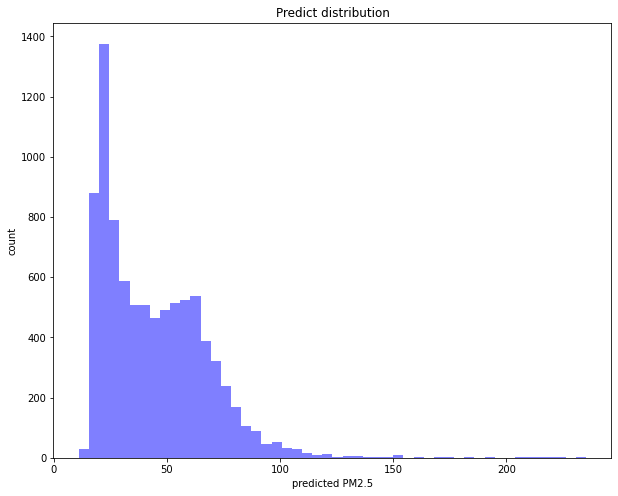

In [300]:
plt.figure(figsize=(10, 8))
plt.hist(preds, bins=50, facecolor='b', alpha=0.5)
plt.xlabel('predicted PM2.5')
plt.ylabel('count')
plt.title('Predict distribution')
plt.show()

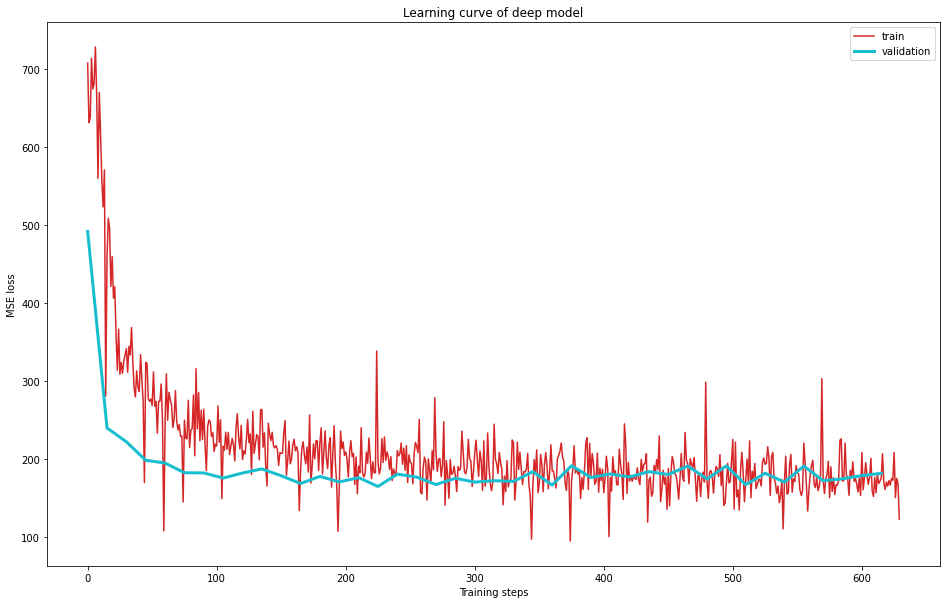

In [301]:
def plot_learning_curve(loss_record, title=''):
    ## plot by steps for training, by epoc for validating
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    plt.figure(figsize=(16, 10))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='validation', lw=3)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

plot_learning_curve(model_loss_record, title='deep model')

# Upload Format

In [302]:
preds_df = pd.DataFrame(np.array([np.array(range(1, len(preds)+1)), preds]).T, columns=["INDEX", "PM2.5"])
preds_df["INDEX"] = preds_df["INDEX"].astype(int)
preds_df.to_csv("temp.csv", index=False)